In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications import VGG16
from keras.optimizers import Adam


In [2]:
train_dir = "/home/hasan/Data Set/aerial-cactus-identification/train/"
test_dir = "/home/hasan/Data Set/aerial-cactus-identification/test/" 

train_df = pd.read_csv('/home/hasan/Data Set/aerial-cactus-identification/train.csv')
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


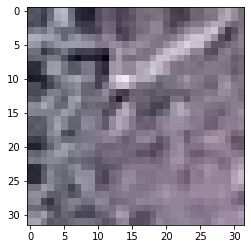

In [3]:
im = cv2.imread("/home/hasan/Data Set/aerial-cactus-identification/train/01e30c0ba6e91343a12d2126fcafc0dd.jpg")
plt.imshow(im)


In [4]:
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(32, 32, 3))


In [5]:
vgg16_net.trainable = False
vgg16_net.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [6]:
model = Sequential()
model.add(vgg16_net)
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))


In [7]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])


In [8]:
X_tr = []
Y_tr = []
imges = train_df['id'].values
for img_id in tqdm_notebook(imges):
    X_tr.append(cv2.imread(train_dir + img_id))    
    Y_tr.append(train_df[train_df['id'] == img_id]['has_cactus'].values[0])  
X_tr = np.asarray(X_tr)
X_tr = X_tr.astype('float32')
X_tr /= 255
Y_tr = np.asarray(Y_tr)


<ipython-input-8-6597ad4cbb31>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_id in tqdm_notebook(imges):


In [9]:
batch_size = 32
nb_epoch = 3

In [10]:
# Train model
history = model.fit(X_tr, Y_tr,
              batch_size=batch_size,
              epochs=nb_epoch,
              validation_split=0.1,
              shuffle=True,
              verbose=2)


Epoch 1/3
493/493 - 103s - loss: 0.5457 - accuracy: 0.7316 - val_loss: 0.4623 - val_accuracy: 0.7463
Epoch 2/3
493/493 - 104s - loss: 0.4445 - accuracy: 0.7779 - val_loss: 0.3912 - val_accuracy: 0.7680
Epoch 3/3
493/493 - 105s - loss: 0.3879 - accuracy: 0.8128 - val_loss: 0.3435 - val_accuracy: 0.8263


<AxesSubplot:>

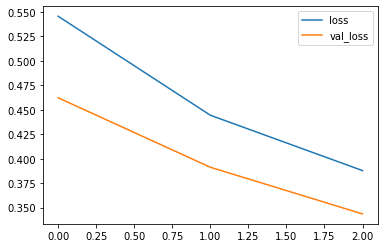

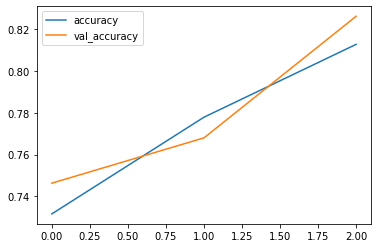

In [14]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()


In [15]:
X_tst = []
Test_imgs = []
for img_id in tqdm_notebook(os.listdir(test_dir)):
    X_tst.append(cv2.imread(test_dir + img_id))     
    Test_imgs.append(img_id)
X_tst = np.asarray(X_tst)
X_tst = X_tst.astype('float32')
X_tst /= 255



<ipython-input-15-80a664303bbc>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_id in tqdm_notebook(os.listdir(test_dir)):


In [16]:
# Prediction
test_predictions = model.predict(X_tst)

In [22]:
sub_df = pd.DataFrame(test_predictions, columns=['has_cactus'])
sub_df['has_cactus'] = sub_df['has_cactus'].apply(lambda x: 1 if x > 0.75 else 0)
sub_df.head()

,has_cactus
0,1
1,1
2,0
3,0
4,1


In [23]:
sub_df['id'] = ''
cols = sub_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
sub_df=sub_df[cols]
sub_df

,id,has_cactus
0,,1
1,,1
2,,0
3,,0
4,,1
...,...,...
3995,,0
3996,,1
3997,,1
3998,,1


In [25]:
for i, img in enumerate(Test_imgs):
    sub_df.loc[i,'id'] = img


In [26]:
sub_df.head()


,id,has_cactus
0,cfc77677a01c059df8962313f90806a1.jpg,1
1,0761683dcd4465630d021224b87f31f9.jpg,1
2,1249cab73ba9b8441be4c63d2218a08b.jpg,0
3,420ccaa9eddcd341b11e8132b43e6f11.jpg,0
4,ea05af568b15f5b721eea4ebdad1855a.jpg,1
